In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
import gc
from tqdm import tqdm_notebook
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
tqdm.pandas()

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
trans_cat_cols = ["ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2","P_emaildomain_bin","P_emaildomain_suffix",
                   "R_emaildomain_bin","R_emaildomain_suffix","M1","M2","M3","M4","M5","M6","M7","M8","M9"]

iden_cat_cols = ["DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32","id_33","id_34","id_35","id_36",
                   "id_37","id_38"]

In [4]:
def transform_transaction_catcols(df1, df2):
    for cat_col in tqdm_notebook( trans_cat_cols): 
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cat_col].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cat_col].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cat_col].dropna() ), set(df2[cat_col].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cat_col].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cat_col].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] = np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] = np.NaN
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect()
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

def transform_identity_catcols(df1,df2):
    for cat_col in tqdm_notebook( iden_cat_cols ): 
        
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cat_col].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cat_col].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cat_col].dropna() ), set(df2[cat_col].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cat_col].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cat_col].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] =  np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] =  np.NaN
        
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect();
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

## 1. Preprocessing

Improving BaseLine IEEE Model 9551 - ka.ipynb에서 피처들을 저장한 파일. 

In [26]:
train_df = pd.read_pickle('./input/train_df_NEWBASELINE_v2.pickle')
test_df = pd.read_pickle('./input/test_df_NEWBASELINE_v2.pickle')

In [27]:
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card4'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card4'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

## 2. Feature Engineering 

account_make_date_D1_card1의 M값의 합 

In [28]:
train_df['account_make_date_D1_card1'] = train_df['card1'].astype(np.str) +'_'+train_df['account_make_date_D1'].astype(np.str)
test_df['account_make_date_D1_card1'] = test_df['card1'].astype(np.str) +'_'+test_df['account_make_date_D1'].astype(np.str)

In [29]:
m_cols = [ 'M1','M2','M3','M4','M5','M6','M7','M8','M9' ]

In [30]:
train_df = pd.get_dummies( train_df , columns=m_cols, dummy_na=True )
test_df = pd.get_dummies( test_df , columns=m_cols, dummy_na=True )

In [31]:
new_m_cols = [ 'M1_F', 'M1_T', 'M1_nan', 'M2_F', 'M2_T', 'M2_nan', 'M3_F', 'M3_T',
 'M3_nan', 'M4_M0', 'M4_M1', 'M4_M2', 'M4_nan', 'M5_F', 'M5_T', 'M5_nan',
 'M6_F', 'M6_T', 'M6_nan', 'M7_F', 'M7_T', 'M7_nan', 'M8_F', 'M8_T', 'M8_nan', 'M9_F', 'M9_T', 'M9_nan']

In [32]:
temp_df = pd.concat([ train_df[ ['account_make_date_D1_card1'] + new_m_cols ], 
                                     test_df[ ['account_make_date_D1_card1'] + new_m_cols ] ], axis=0) .groupby('account_make_date_D1_card1')[new_m_cols].sum()

temp_df.columns = [col+'_sum' for col in temp_df]

train_df = pd.merge(train_df, temp_df, left_on = 'account_make_date_D1_card1', right_index=True, how='left')
test_df = pd.merge(test_df, temp_df, left_on = 'account_make_date_D1_card1', right_index=True, how='left')

HyunwooKim - 9635 변수 테스트

In [33]:
# 처음 방문한 고객과 그렇지 않은 고객으로 나누어서 계산 
total_df = pd.concat([train_df,test_df],axis=0,sort=False)
total_df_new = total_df[total_df['D1']==0]
total_df_original = total_df[total_df['D1']!=0]

In [34]:
total_df = total_df.merge(total_df_new.groupby(['uid2'])['TransactionAmt'].agg({'std'}).reset_index().rename(columns={'std':'new_uid2_transactionamt_std'}), how='left',on='uid2')
total_df = total_df.merge(total_df_original.groupby(['uid2'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'hist_uid2_transactionamt_mean', 'std':'hist_uid2_transactionamt_std'}), how='left',on='uid2')

In [35]:
total_df = total_df.merge(total_df_new.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'sum'}).reset_index().rename(columns={'sum':'new_card1_make_d1_sum'}),how='left',on=['card1','account_make_date_D1','ProductCD'])
total_df = total_df.merge(total_df_original.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'sum'}).reset_index().rename(columns={'sum':'hist_card1_make_d1_sum'}),how='left',on=['card1','account_make_date_D1','ProductCD'])

In [36]:
total_df = total_df.merge(total_df_new.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionID'].agg({'count'}).reset_index().rename(columns={'count':'new_card1_make_d1_count'}),how='left',on=['card1','account_make_date_D1','ProductCD'])
total_df = total_df.merge(total_df_original.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionID'].agg({'count'}).reset_index().rename(columns={'count':'hist_card1_make_d1_count'}),how='left',on=['card1','account_make_date_D1','ProductCD'])

total_df['new_card1_make_d1_count'] = total_df['new_card1_make_d1_count'].fillna(0)
total_df['hist_card1_make_d1_count'] = total_df['hist_card1_make_d1_count'].fillna(0)
total_df['card1_make_d1_count_ratio'] = total_df['hist_card1_make_d1_count'] / (total_df['new_card1_make_d1_count']+1)

In [37]:
total_df['new_card1_make_d1_sum'] = total_df['new_card1_make_d1_sum'].fillna(0)
total_df['hist_card1_make_d1_sum'] = total_df['hist_card1_make_d1_sum'].fillna(0)
total_df['card1_make_d1_count_sum_ratio'] = total_df['hist_card1_make_d1_sum'] / (total_df['new_card1_make_d1_sum']+1)

In [38]:
# sampling에서는 조금 올랐는데 전체 데이터셋에서 좋아졌는지는 확인하지 못했음. 
total_df = total_df.merge(total_df.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD','account_make_date_D1'])['hour'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_hour_mean','std':'uid2_hour_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD','account_make_date_D1'])

연민님 변수 추가 

In [39]:
del total_df['card1_addr1']
del total_df['card1_addr1_count_full']

In [40]:
def category_combine_feature(all_data, c1, c2):
    new_col_list = []
    new_col = f'{c1}_{c2}_combine'
    all_data[new_col] = all_data[c1].astype(str) + '_' + all_data[c2].astype(str)
    all_data[new_col] = pd.factorize(all_data[new_col], sort=True)[0]
    
    new_col_freq = new_col + '_fq_enc_combine'
    fq_encode = all_data[new_col].value_counts().to_dict()   
    all_data[new_col_freq] = all_data[new_col].map(fq_encode)

    return all_data

In [41]:
for a in ['addr1']:
    for i in ['id_32','id_14','id_19']:
        total_df = category_combine_feature(total_df,a,i)
        
for c in ['card1']:
    for i in ['card2','addr1']:
        total_df = category_combine_feature(total_df,c,i)

분할 

In [42]:
train_df = total_df[total_df['isFraud'].notnull()]
test_df = total_df[total_df['isFraud'].isnull()]

In [43]:
# 기존의 uid2_next_click을 아래와 같이 수정했음. 
train_df['uid2_next_click'] = train_df['TransactionDT'] - train_df.groupby(['uid2','account_make_date_D1'])['TransactionDT'].shift(-1)
test_df['uid2_next_click'] = test_df['TransactionDT'] - test_df.groupby(['uid2','account_make_date_D1'])['TransactionDT'].shift(-1)

새로운 카테고리 컬럼들의 Frequency_encoding 

In [44]:
for i in ['M1_F', 'M1_T', 'M1_nan', 'M2_F', 'M2_T', 'M2_nan', 'M3_F', 'M3_T', 'M3_nan', 'M4_M0', 'M4_M1', 'M4_M2', 'M4_nan', 'M5_F', 'M5_T', 'M5_nan', 'M6_F', 'M6_T', 'M6_nan', 'M7_F', 'M7_T', 'M7_nan', 'M8_F', 'M8_T', 'M8_nan', 'M9_F', 'M9_T', 'M9_nan', 'M1_F_sum', 'M1_T_sum', 'M1_nan_sum', 'M2_F_sum', 'M2_T_sum', 'M2_nan_sum', 'M3_F_sum', 'M3_T_sum', 'M3_nan_sum', 'M4_M0_sum', 'M4_M1_sum', 'M4_M2_sum', 'M4_nan_sum', 'M5_F_sum', 'M5_T_sum', 'M5_nan_sum', 'M6_F_sum', 'M6_T_sum', 'M6_nan_sum', 'M7_F_sum', 'M7_T_sum', 'M7_nan_sum', 'M8_F_sum', 'M8_T_sum', 'M8_nan_sum', 'M9_F_sum', 'M9_T_sum', 'M9_nan_sum']:
    train_df['{}_count_full'.format(i)] = train_df[i].map(pd.concat([train_df[i], test_df[i]], ignore_index=True).value_counts(dropna=False))
    test_df['{}_count_full'.format(i)] = test_df[i].map(pd.concat([train_df[i], test_df[i]], ignore_index=True).value_counts(dropna=False))

변수 제거하는 부분 (건들면 안됨) 

In [45]:
drop_cols = ['account_make_date_D1_card1','ProductCD_D1_Amt_byDate']
train_df.drop(drop_cols,1,inplace=True)
test_df.drop(drop_cols,1,inplace=True)

In [47]:
train_df['d1_d2'] = train_df['account_make_date_D1'].astype(str) + '_' + train_df['account_make_date_D2'].astype(str) + '_' + train_df['ProductCD'].astype(str)
test_df['d1_d2'] = test_df['account_make_date_D1'].astype(str) + '_' + test_df['account_make_date_D2'].astype(str) + '_' + test_df['ProductCD'].astype(str)

In [60]:
train_df['same_d1_d2'] = 0
test_df['same_d1_d2'] = 0

train_df.loc[train_df['account_make_date_D1'] == train_df['account_make_date_D2'], 'same_d1_d2'] = 1
test_df.loc[test_df['account_make_date_D1'] == test_df['account_make_date_D2'], 'same_d1_d2'] = 1

In [48]:
for i in tqdm_notebook(['d1_d2']):
    train_df['{}_count_full'.format(i)] = train_df[i].map(pd.concat([train_df[i], test_df[i]], ignore_index=True).value_counts(dropna=False))
    test_df['{}_count_full'.format(i)] = test_df[i].map(pd.concat([train_df[i], test_df[i]], ignore_index=True).value_counts(dropna=False))

### Label Encoding 

In [49]:
from sklearn.preprocessing import LabelEncoder

for col in tqdm_notebook(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   

## Feature selection : LightGBM - Adversarial Validation 

In [50]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [82]:
features = [c for c in train_df.columns if c not in ['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
                                                    , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
                                                    , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
                                                    , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
                                                    , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'account_make_date',
       'account_make_date_D3', 'account_make_date_D4',
       'account_make_date_D7', 'account_make_date_D8',
       'account_make_date_D11', 'account_make_date_D12',
       'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
       'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std','DT_M','Transactionhourcount','account_make_date_D1_card1','account_make_date_D2']]

## Sampling - LightGBM - 6FOLD

In [52]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [53]:
train_df['DT_M'] = (train_df['year']-2017)*12 + train_df['month'] 
test_df['DT_M'] = (test_df['year']-2017)*12 + test_df['month']

In [30]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
sampling = True
if sampling == True:
    normal_data = train_df[train_df['isFraud'] == 0].reset_index(drop=True)
    fraud_data = train_df[train_df['isFraud'] == 1].reset_index(drop=True)
    normal_data, _ = train_test_split(normal_data, test_size=0.9637412985609175, random_state=42, stratify=normal_data['DT_M']) # if want to split 1:1 test_size = 0.9637412985609175
    train_df_sample = pd.concat([normal_data, fraud_data],axis=0)
    train_df_sample = train_df_sample.sort_values(by='TransactionID').reset_index(drop=True)

In [31]:
import datetime 
if sampling == True:
    y = train_df_sample['isFraud']
    X = train_df_sample[features].reset_index(drop=True)

    test = test_df[features].reset_index(drop=True)

    from time import time
    from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

    NFOLD = 6
    folds =  GroupKFold(n_splits=NFOLD)
    split_groups = train_df_sample['DT_M']

    aucs = list()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns
    oofs = np.zeros(len(train_df_sample))
    preds = np.zeros(len(test_df))

    training_start_time = time()
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
        clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds=100)
        oofs[test_idx] = clf.predict(X.iloc[test_idx])
        # preds += clf.predict(test)/NFOLD

        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
        aucs.append(clf.best_score['valid_1']['auc'])

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('Mean AUC:', np.mean(aucs))
    print("Total Validation: ", roc_auc_score(y, oofs))
    print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.979778	valid_1's auc: 0.896308
[1000]	training's auc: 0.997302	valid_1's auc: 0.912898
[1500]	training's auc: 0.999858	valid_1's auc: 0.916955
Early stopping, best iteration is:
[1823]	training's auc: 0.99999	valid_1's auc: 0.917593
Fold 1 finished in 0:02:49.198525
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.979956	valid_1's auc: 0.93386
[1000]	training's auc: 0.997309	valid_1's auc: 0.946415
[1500]	training's auc: 0.999867	valid_1's auc: 0.950106
[2000]	training's auc: 0.999999	valid_1's auc: 0.951331
Early stopping, best iteration is:
[2395]	training's auc: 1	valid_1's auc: 0.951733
Fold 2 finished in 0:03:43.299759
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.979364	valid_1's auc: 0.926502
[1000]	training's auc: 0.997177	valid_1's auc: 0.942613
[1500]	train

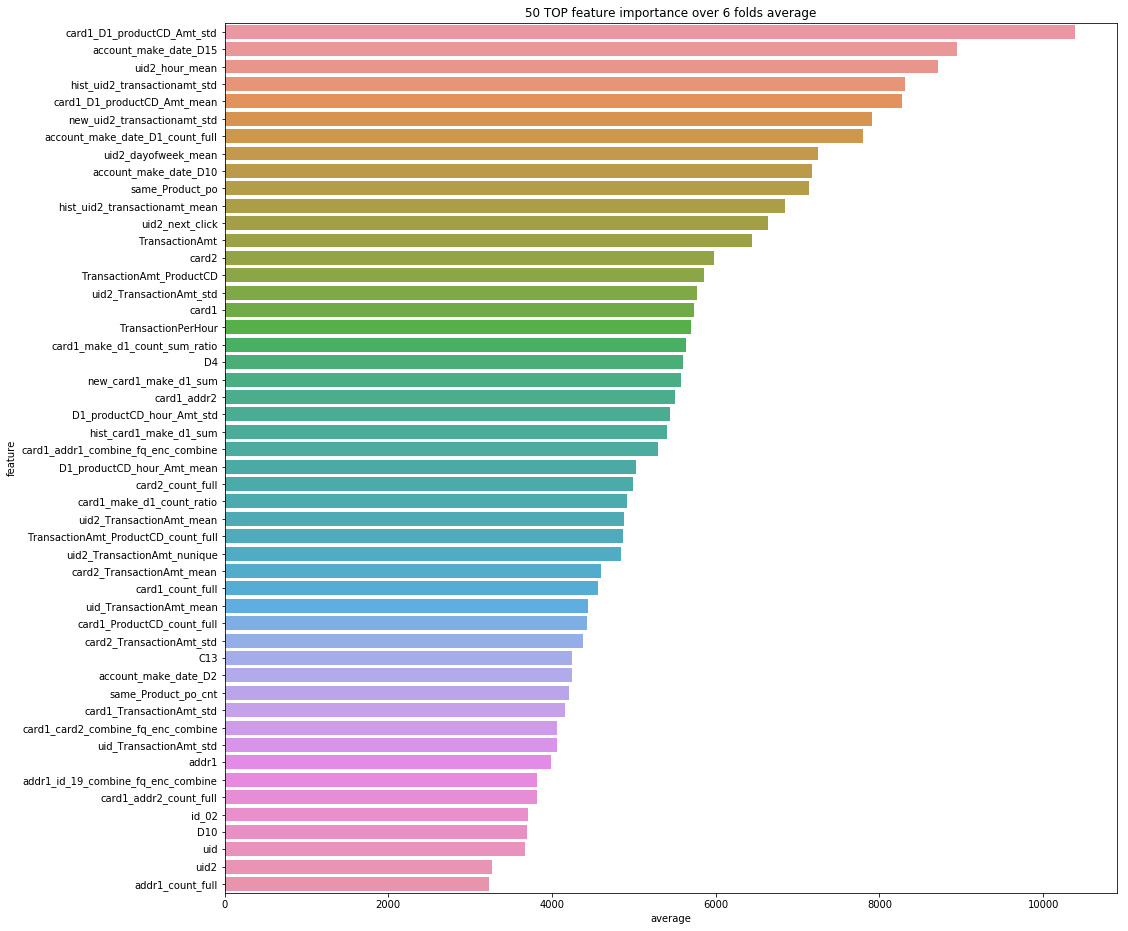

In [32]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

## RandomForestClassifier - Covariate Shift

## LightGBM - 8 : 2 Split 

In [54]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [55]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [56]:
train_df['DT_M'] = (train_df['year']-2017)*12 + train_df['month'] 
test_df['DT_M'] = (test_df['year']-2017)*12 + test_df['month']

In [62]:
y = train_df['isFraud']
X = train_df[features].reset_index(drop=True)

test = test_df[features].reset_index(drop=True)

### Group K fold 

In [63]:
from time import time
import datetime 

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

NFOLD = 6
folds =  GroupKFold(n_splits=NFOLD)
split_groups = train_df['DT_M']

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros(len(test_df))

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds=100)
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test)/NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print("Total Validation: ", roc_auc_score(y, oofs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.993595	valid_1's auc: 0.910713
[1000]	training's auc: 0.999724	valid_1's auc: 0.921282
[1500]	training's auc: 0.999995	valid_1's auc: 0.924582
[2000]	training's auc: 1	valid_1's auc: 0.925757
Early stopping, best iteration is:
[2151]	training's auc: 1	valid_1's auc: 0.925866
Fold 1 finished in 0:15:00.721888
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.993144	valid_1's auc: 0.947029
[1000]	training's auc: 0.999713	valid_1's auc: 0.955068
[1500]	training's auc: 0.999995	valid_1's auc: 0.956822
[2000]	training's auc: 1	valid_1's auc: 0.957243
Early stopping, best iteration is:
[1958]	training's auc: 1	valid_1's auc: 0.957278
Fold 2 finished in 0:13:53.824577
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.992461	valid_1's auc: 0.949109
[1000]	training's auc: 0.999659

In [116]:
train_df.shape

(590540, 690)

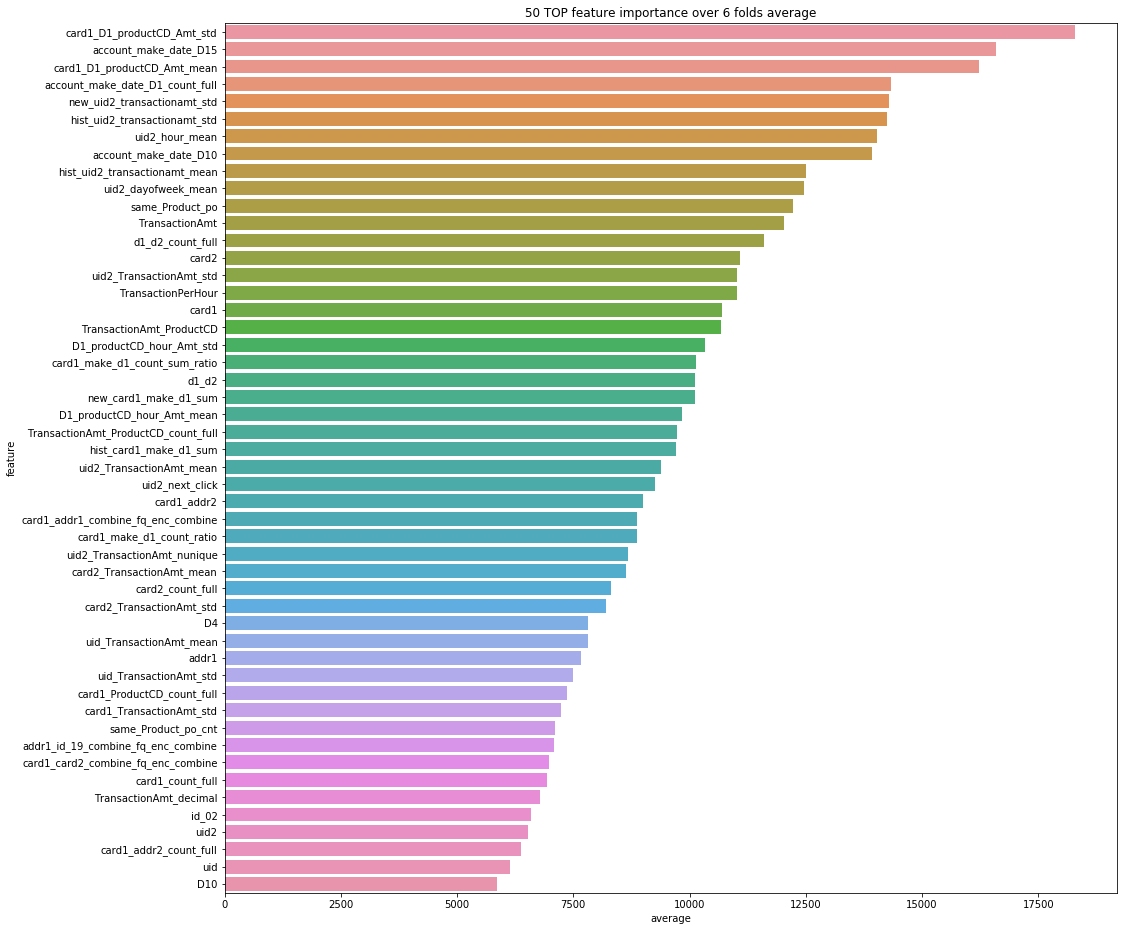

In [64]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [65]:
feature_importances.sort_values(by='average',ascending=False).head()

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,average
500,card1_D1_productCD_Amt_std,19850,17870,15932,15022,22114,18943,18288.500000
382,account_make_date_D15,18365,15992,14671,13645,19495,17374,16590.333333
501,card1_D1_productCD_Amt_mean,17907,15749,14711,13739,19485,15754,16224.166667
514,account_make_date_D1_count_full,16201,14115,12591,11565,17256,14277,14334.166667
574,new_uid2_transactionamt_std,15476,13892,12960,12219,16911,14306,14294.000000


In [66]:
sub1 = pd.read_csv("input/sample_submission.csv")
sub1['isFraud'] = preds
sub1.to_csv('NEW_BASELINE_TEST2_v106.csv', index=False)

In [74]:
sub1 = pd.read_csv("NEW_BASELINE_TEST2_v106.csv")

In [72]:
total_df = pd.concat([train_df,test_df],axis=0)
total_df = total_df[['TransactionID','d1_d2','isFraud','same_d1_d2']]
total_df['shift_Fraud'] = total_df.groupby(['d1_d2'])['isFraud'].shift(1)

In [76]:
sub_df = total_df[train_df.shape[0]:]
sub_df['isFraud'] = sub1['isFraud'].values
sub_df

,TransactionID,d1_d2,isFraud,same_d1_d2,shift_Fraud
590540,3663549,4144,0.000547,1,0.0
590541,3663550,8974,0.000687,1,0.0
590542,3663551,9237,0.001023,1,0.0
590543,3663552,11124,0.000610,1,0.0
590544,3663553,11469,0.000566,1,NaN
590545,3663554,11238,0.001089,1,0.0
590546,3663555,14662,0.005019,0,0.0
590547,3663556,14662,0.004571,0,NaN
590548,3663557,9419,0.000156,1,0.0
590549,3663558,10585,0.001166,1,0.0


In [80]:
sub_df.loc[(sub_df['same_d1_d2'] == 0) & (sub_df['shift_Fraud'].notnull()), 'isFraud'] = sub_df.loc[(sub_df['same_d1_d2'] == 0) & (sub_df['shift_Fraud'].notnull()), 'shift_Fraud']
sub_df = sub_df[['TransactionID','isFraud']]
sub_df.shape

(506691, 2)

In [81]:
sub_df.to_csv("gotoschool.csv",index=False)

In [67]:
features = [c for c in train_df.columns if c not in ['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
                                                    , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
                                                    , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
                                                    , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
                                                    , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'account_make_date',
       'account_make_date_D3', 'account_make_date_D4',
       'account_make_date_D7', 'account_make_date_D8',
       'account_make_date_D11', 'account_make_date_D12',
       'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
       'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std','DT_M','Transactionhourcount','account_make_date_D1_card1','account_make_date_D2','same_d1_d2']]

In [68]:
y = train_df['isFraud']
X = train_df[features].reset_index(drop=True)

test = test_df[features].reset_index(drop=True)

In [69]:
from time import time
import datetime 

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

NFOLD = 6
folds =  GroupKFold(n_splits=NFOLD)
split_groups = train_df['DT_M']

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros(len(test_df))

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds=100)
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test)/NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print("Total Validation: ", roc_auc_score(y, oofs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.993554	valid_1's auc: 0.910711
[1000]	training's auc: 0.999715	valid_1's auc: 0.922439
[1500]	training's auc: 0.999995	valid_1's auc: 0.925779
Early stopping, best iteration is:
[1889]	training's auc: 1	valid_1's auc: 0.926517
Fold 1 finished in 0:12:54.274706
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.99314	valid_1's auc: 0.947656
[1000]	training's auc: 0.999717	valid_1's auc: 0.9554
[1500]	training's auc: 0.999995	valid_1's auc: 0.956924
Early stopping, best iteration is:
[1812]	training's auc: 1	valid_1's auc: 0.957226
Fold 2 finished in 0:12:27.372992
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.992443	valid_1's auc: 0.948955
[1000]	training's auc: 0.99964	valid_1's auc: 0.957563
[1500]	training's auc: 0.999994	valid_1's auc: 0.959625
[2000]	training's auc

In [70]:
sub1 = pd.read_csv("input/sample_submission.csv")
sub1['isFraud'] = preds
sub1.to_csv('NEW_BASELINE_TEST2_v106_2.csv', index=False)

In [183]:
overfitting_features = ['C9', 'D3', 'V12', 'V32', 'V36', 'V78', 'V108', 'V112', 'V136',
       'V174', 'V176', 'V178', 'V216', 'V230', 'V236', 'V294', 'V308',
       'V332', 'm_comb', 'R_emaildomain_count_full',
       'email_null_concat_count_full', 'card1_addr1_count_full',
       'addr1_addr2_count_full', 'D1_productCD_hour_Amt_std', 'D_mean',
       'addr1', 'D9', 'V14', 'V110', 'V162', 'V326', 'card6_count_full',
       'addr1_addr2_count_full', 'V26', 'V138', 'V170', 'V274', 'V290',
       'V210', 'V114', 'V306']

In [184]:
features = [c for c in train_df.columns if c not in np.append(['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
                                                    , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
                                                    , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
                                                    , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
                                                    , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'account_make_date',
       'account_make_date_D3', 'account_make_date_D4',
       'account_make_date_D7', 'account_make_date_D8',
       'account_make_date_D11', 'account_make_date_D12',
       'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
       'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std','DT_M','Transactionhourcount','account_make_date_D1_card1'],overfitting_features)]

In [185]:
y = train_df['isFraud']
X = train_df[features].reset_index(drop=True)

test = test_df[features].reset_index(drop=True)

In [186]:
from time import time
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

NFOLD = 6
folds =  GroupKFold(n_splits=NFOLD)
split_groups = train_df['DT_M']

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros(len(test_df))

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds=100)
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test)/NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print("Total Validation: ", roc_auc_score(y, oofs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.993429	valid_1's auc: 0.912403
[1000]	training's auc: 0.999699	valid_1's auc: 0.922646
[1500]	training's auc: 0.999994	valid_1's auc: 0.925537
[2000]	training's auc: 1	valid_1's auc: 0.926056
Early stopping, best iteration is:
[2200]	training's auc: 1	valid_1's auc: 0.926254
Fold 1 finished in 0:13:41.678023
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.992928	valid_1's auc: 0.946595
[1000]	training's auc: 0.999678	valid_1's auc: 0.954265
[1500]	training's auc: 0.999994	valid_1's auc: 0.955782
[2000]	training's auc: 1	valid_1's auc: 0.956192
Early stopping, best iteration is:
[1959]	training's auc: 1	valid_1's auc: 0.956235
Fold 2 finished in 0:12:48.545641
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.992228	valid_1's auc: 0.948921
[1000]	training's auc: 0.999629

In [187]:
subx = pd.read_csv("input/sample_submission.csv")
subx['isFraud'] = preds
subx.to_csv('NEW_BASELINE_TEST2_v104_lgb_new.csv', index=False)

## CATBOOST

In [83]:
import random
import os 
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [84]:
import datetime 
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [85]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

def make_predictions(tr_df, tt_df, features_columns, target, cat_params, NFOLDS=2, kfold_mode='grouped'):
    
    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  
    split_groups = tr_df['DT_M']

    tt_df = tt_df[['TransactionID',target]] 
    tr_df = tr_df[['TransactionID',target]] 
    
    predictions = np.zeros(len(tt_df))
    oof = np.zeros(len(tr_df))

    if kfold_mode=='grouped':
        folds = GroupKFold(n_splits=NFOLDS)
        folds_split = folds.split(X, y, groups=split_groups)
    else:
        folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
        folds_split = folds.split(X, y)

    for fold_, (trn_idx, val_idx) in enumerate(folds_split):        
        print('Fold:',fold_)
        
        estimator = CatBoostClassifier(**cat_params)        
        estimator.fit(
            X.iloc[trn_idx,:],y[trn_idx],
            eval_set=(X.iloc[val_idx,:], y[val_idx]),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True)
        
        pp_p = estimator.predict_proba(P)[:,1]
        predictions += pp_p/NFOLDS
        
        oof_preds = estimator.predict_proba(X.iloc[val_idx,:])[:,1]
        oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())
        
        del estimator
        gc.collect()
        
    tt_df['prediction'] = predictions
    print('OOF AUC:', metrics.roc_auc_score(y, oof))
    if LOCAL_TEST:
        print('Holdout AUC:', metrics.roc_auc_score(tt_df[TARGET], tt_df['prediction']))
    
    return tt_df
## -------------------

In [86]:
########################### Model params
cat_params = {
                'n_estimators':5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':SEED,
                'metric_period':500,
                'od_wait':500,
                'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 

In [88]:
features_columns = features

categorical_features = ['card1','card2','addr1','addr2','P_emaildomain','R_emaildomain','TransactionAmt_decimal','email_type',
 'account_make_date_D10', 'account_make_date_D15', 'card1_addr2','addr1_addr2','DeviceType','DeviceInfo','id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
 'addr1_id_32_combine', 'addr1_id_32_combine_fq_enc_combine',  'addr1_id_14_combine', 'addr1_id_14_combine_fq_enc_combine', 'addr1_id_19_combine', 'addr1_id_19_combine_fq_enc_combine', 'card1_card2_combine', 'card1_card2_combine_fq_enc_combine', 'card1_addr1_combine', 'card1_addr1_combine_fq_enc_combine','same_d1_d2','d1_d2']

In [89]:
for col in tqdm_notebook( features ):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
    
    elif col in categorical_features:
        train_df[col] = train_df[col].astype(float).fillna(-999)
        test_df[col]  = test_df[col].astype(float).fillna(-999)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])

In [ ]:
features

['TransactionAmt',
 'card1',
 'card2',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',


In [ ]:
if LOCAL_TEST:
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, cat_params, 
                                        NFOLDS=4, kfold_mode='grouped')

else:    
    # Why NFOLDS = 6 -> we have 6 months -> let's split it by month))
    NFOLDS = 6
    folds = GroupKFold(n_splits=NFOLDS)

    test_df[TARGET] = 0.5 
    
    X ,y = train_df[features_columns], train_df[TARGET]    
    P, p_y = test_df[features_columns], test_df[TARGET]  
    
    split_groups = train_df['DT_M']
    # We don't need original sets anymore
    # let's reduce it
    oofs = train_df[['TransactionID',TARGET]]
    preds = test_df[['TransactionID',TARGET]] 
    preds['prediction'] = 0
    gc.collect()
    
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
        print('Fold:',fold_)
        
        estimator = CatBoostClassifier(**cat_params)        
        estimator.fit(
            X.iloc[trn_idx,:],y[trn_idx],
            eval_set=(X.iloc[val_idx,:], y[val_idx]),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True)

        oof_preds = estimator.predict_proba(X.iloc[val_idx,:])[:,1]
        oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())
        preds['prediction'] += estimator.predict_proba(P)[:,1]/NFOLDS
        
        del estimator
        gc.collect()
        
    print('OOF AUC:', roc_auc_score(y, oof))

Fold: 0
0:	learn: 0.8997861	test: 0.7483373	best: 0.7483373 (0)	total: 184ms	remaining: 15m 20s
500:	learn: 0.9820282	test: 0.9360683	best: 0.9360683 (500)	total: 1m 19s	remaining: 11m 57s
1000:	learn: 0.9854068	test: 0.9425000	best: 0.9425447 (994)	total: 2m 41s	remaining: 10m 43s
1500:	learn: 0.9881097	test: 0.9451720	best: 0.9451720 (1500)	total: 4m 2s	remaining: 9m 24s
2000:	learn: 0.9904135	test: 0.9459637	best: 0.9459637 (2000)	total: 5m 24s	remaining: 8m 5s
2500:	learn: 0.9923717	test: 0.9469668	best: 0.9471323 (2484)	total: 6m 46s	remaining: 6m 45s
3000:	learn: 0.9941897	test: 0.9467594	best: 0.9472294 (2613)	total: 8m 8s	remaining: 5m 25s
bestTest = 0.9472293854
bestIteration = 2613
Shrink model to first 2614 iterations.
Fold: 1
0:	learn: 0.8648326	test: 0.8081629	best: 0.8081629 (0)	total: 223ms	remaining: 18m 34s
500:	learn: 0.9800304	test: 0.9557447	best: 0.9557500 (499)	total: 1m 24s	remaining: 12m 43s
1000:	learn: 0.9834756	test: 0.9575837	best: 0.9576771 (995)	total: 2m 

In [142]:
sub2 = pd.read_csv("./input/sample_submission.csv")
sub2['isFraud'] = preds['prediction'].values
sub2.to_csv('NEW_BASELINE_TEST2_cat_v104.csv', index=False)

In [132]:
sub3 = pd.read_csv("v_not_delete.csv")
sub4 = pd.read_csv("9591_cat.csv")

In [146]:
sub = pd.read_csv("./input/sample_submission.csv")
sub['isFraud'] = 0.25 * (sub1['isFraud'] + sub2['isFraud'] + sub3['isFraud'] + sub4['isFraud'])
sub.to_csv("recent_ensemble.csv",index=False)

In [148]:
sub['isFraud'].describe()

count    506691.000000
mean          0.024267
std           0.111526
min           0.000051
25%           0.001053
50%           0.002595
75%           0.007009
max           0.998724
Name: isFraud, dtype: float64

In [139]:
sub2.head()

,TransactionID,isFraud
0,3663549,NaN
1,3663550,NaN
2,3663551,NaN
3,3663552,NaN
4,3663553,NaN


### LGB TEST

In [189]:
features = [c for c in train_df.columns if c not in ['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
                                                    , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
                                                    , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
                                                    , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
                                                    , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'account_make_date',
       'account_make_date_D3', 'account_make_date_D4',
       'account_make_date_D7', 'account_make_date_D8',
       'account_make_date_D11', 'account_make_date_D12',
       'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
       'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std','DT_M','Transactionhourcount','account_make_date_D1_card1']]

In [191]:
for col in tqdm_notebook( features ):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
    
    elif col in categorical_features:
        train_df[col] = train_df[col].astype(float).fillna(-999)
        test_df[col]  = test_df[col].astype(float).fillna(-999)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])

In [192]:
y = train_df['isFraud']
X = train_df[features].reset_index(drop=True)

test = test_df[features].reset_index(drop=True)

In [193]:
from time import time
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

NFOLD = 6
folds =  GroupKFold(n_splits=NFOLD)
split_groups = train_df['DT_M']

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(train_df))
preds = np.zeros(len(test_df))

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds=100)
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test)/NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print("Total Validation: ", roc_auc_score(y, oofs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.993311	valid_1's auc: 0.912795
[1000]	training's auc: 0.999702	valid_1's auc: 0.923382
[1500]	training's auc: 0.999995	valid_1's auc: 0.926598
[2000]	training's auc: 1	valid_1's auc: 0.927668
Early stopping, best iteration is:
[2302]	training's auc: 1	valid_1's auc: 0.927769
Fold 1 finished in 0:15:39.494255
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.993035	valid_1's auc: 0.947328
[1000]	training's auc: 0.999694	valid_1's auc: 0.954916
[1500]	training's auc: 0.999995	valid_1's auc: 0.956576
Early stopping, best iteration is:
[1761]	training's auc: 1	valid_1's auc: 0.956915
Fold 2 finished in 0:12:44.737564
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.992317	valid_1's auc: 0.949634
[1000]	training's auc: 0.999637	valid_1's auc: 0.957606
[1500]	training's auc: 0

In [194]:
suby = pd.read_csv("input/sample_submission.csv")
suby['isFraud'] = preds
suby.to_csv('NEW_BASELINE_TEST2_v104_lgb_new2.csv', index=False)